## 6. END TO END APPLICATION - TITANIC

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 170)

def load_titanic():
    data = pd.read_csv("titanic.csv")
    return data

df = load_titanic()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [13]:
df.shape

(891, 12)

In [14]:
#############################################
# 1. FEATURE ENGINEERING
#############################################

df["NEW_CABIN_BOOL"] = df["Cabin"].isnull().astype('int')
df["NEW_NAME_COUNT"] = df["Name"].str.len()
df["NEW_NAME_WORD_COUNT"] = df["Name"].apply(lambda x: len(str(x).split(" ")))
df["NEW_NAME_DR"] = df["Name"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))
df['NEW_TITLE'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df["NEW_FAMILY_SIZE"] = df["SibSp"] + df["Parch"] + 1
df["NEW_AGE_PCLASS"] = df["Age"] * df["Pclass"]

df.loc[((df['SibSp'] + df['Parch']) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df['SibSp'] + df['Parch']) == 0), "NEW_IS_ALONE"] = "YES"

df.loc[(df['Age'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['Age'] >= 18) & (df['Age'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['Age'] >= 56), 'NEW_AGE_CAT'] = 'senior'

df.loc[(df['Sex'] == 'male') & (df['Age'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['Sex'] == 'male') & ((df['Age'] > 21) & (df['Age']) < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['Sex'] == 'male') & (df['Age'] > 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['Sex'] == 'female') & (df['Age'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['Sex'] == 'female') & ((df['Age'] > 21) & (df['Age']) < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['Sex'] == 'female') & (df['Age'] > 50), 'NEW_SEX_CAT'] = 'seniorfemale'

df.columns = [col.upper() for col in df.columns]
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,1,23,4,0,Mr,2,66.000,NO,mature,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,0,51,7,0,Mrs,2,38.000,NO,mature,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,1,22,3,0,Miss,1,78.000,YES,mature,maturefemale
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,0,44,7,0,Mrs,2,35.000,NO,mature,maturefemale
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,1,24,4,0,Mr,1,105.000,YES,mature,maturemale


In [15]:
df.shape

(891, 22)

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PASSENGERID,891.000,446.000,257.354,1.000,223.500,446.000,668.500,891.000
SURVIVED,891.000,0.384,0.487,0.000,0.000,0.000,1.000,1.000
PCLASS,891.000,2.309,0.836,1.000,2.000,3.000,3.000,3.000
AGE,714.000,29.699,14.526,0.420,20.125,28.000,38.000,80.000
SIBSP,891.000,0.523,1.103,0.000,0.000,0.000,1.000,8.000
PARCH,891.000,0.382,0.806,0.000,0.000,0.000,0.000,6.000
FARE,891.000,32.204,49.693,0.000,7.910,14.454,31.000,512.329
NEW_CABIN_BOOL,891.000,0.771,0.420,0.000,1.000,1.000,1.000,1.000
NEW_NAME_COUNT,891.000,26.965,9.282,12.000,20.000,25.000,30.000,82.000
NEW_NAME_WORD_COUNT,891.000,4.070,1.171,3.000,3.000,4.000,4.000,14.000


In [18]:
def outlier_thresholds(dataframe, col_name):
    quartile1 = dataframe[col_name].quantile(0.05)
    quartile3 = dataframe[col_name].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if low_limit > 0:
        dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
        dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit
    else:
        dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

In [19]:
#############################################
# 2. AYKIRI GOZLEM
#############################################

num_cols = [col for col in df.columns if len(df[col].unique()) > 20
            and df[col].dtypes != 'O'
            and col not in "PASSENGERID"]

for col in num_cols:
    replace_with_thresholds(df, col)
    
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PASSENGERID,891.000,446.000,257.354,1.000,223.500,446.000,668.500,891.000
SURVIVED,891.000,0.384,0.487,0.000,0.000,0.000,1.000,1.000
PCLASS,891.000,2.309,0.836,1.000,2.000,3.000,3.000,3.000
AGE,714.000,29.699,14.526,0.420,20.125,28.000,38.000,80.000
SIBSP,891.000,0.523,1.103,0.000,0.000,0.000,1.000,8.000
PARCH,891.000,0.382,0.806,0.000,0.000,0.000,0.000,6.000
FARE,891.000,31.386,43.374,0.000,7.910,14.454,31.000,269.360
NEW_CABIN_BOOL,891.000,0.771,0.420,0.000,1.000,1.000,1.000,1.000
NEW_NAME_COUNT,891.000,26.965,9.282,12.000,20.000,25.000,30.000,82.000
NEW_NAME_WORD_COUNT,891.000,4.070,1.171,3.000,3.000,4.000,4.000,14.000


In [21]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns
missing_values_table(df)

                n_miss  ratio
CABIN              687 77.100
NEW_AGE_CAT        177 19.870
NEW_AGE_PCLASS     177 19.870
AGE                177 19.870
EMBARKED             2  0.220


In [22]:
#############################################
# 3. EKSIK GOZLEM
#############################################

df.drop("CABIN", inplace=True, axis=1)

remove_vars = ["TICKET", "NAME"]
df.drop(remove_vars, inplace=True, axis=1)

df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))
df["NEW_AGE_PCLASS"] = df["NEW_AGE_PCLASS"].fillna(df.groupby("NEW_TITLE")["NEW_AGE_PCLASS"].transform("median"))


df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [26]:
#############################################
# 4. LABEL ENCODING
#############################################

df.head()
df.shape

binary_cols = [col for col in df.columns if len(df[col].unique()) == 2 and df[col].dtypes == 'O']

def label_encoder(dataframe, binary_col):
    labelencoder = preprocessing.LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

for col in binary_cols:
    df = label_encoder(df, col)

In [34]:
#############################################
# 5. RARE ENCODING
#############################################

def rare_analyser(dataframe, target, rare_perc):

    rare_columns = [col for col in dataframe.columns if dataframe[col].dtypes == 'O'
                    and (dataframe[col].value_counts() / len(dataframe) < rare_perc).any(axis=None)]

    for col in rare_columns:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "SURVIVED", 0.05)

NEW_TITLE : 5
        COUNT  RATIO  TARGET_MEAN
Master     40  0.045        0.575
Miss      182  0.204        0.698
Mr        517  0.580        0.157
Mrs       125  0.140        0.792
Rare       27  0.030        0.444


NEW_AGE_CAT : 3
        COUNT  RATIO  TARGET_MEAN
mature    739  0.829        0.364
senior     39  0.044        0.308
young     113  0.127        0.540


NEW_SEX_CAT : 4
              COUNT  RATIO  TARGET_MEAN
maturefemale    297  0.333        0.731
maturemale      530  0.595        0.194
seniorfemale     17  0.019        0.941
seniormale       47  0.053        0.128




In [35]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

df = rare_encoder(df, 0.05)
rare_analyser(df, "SURVIVED", 0.05)
df.head()

NEW_AGE_CAT : 3
        COUNT  RATIO  TARGET_MEAN
Rare       39  0.044        0.308
mature    739  0.829        0.364
young     113  0.127        0.540


NEW_SEX_CAT : 4
              COUNT  RATIO  TARGET_MEAN
Rare             17  0.019        0.941
maturefemale    297  0.333        0.731
maturemale      530  0.595        0.194
seniormale       47  0.053        0.128




,PASSENGERID,SURVIVED,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,1,22.000,1,0,7.250,S,1,23.000,4,0,Mr,2,66.000,0,mature,maturemale
1,2,1,1,0,38.000,1,0,71.283,C,0,51.000,7,0,Mrs,2,38.000,0,mature,maturefemale
2,3,1,3,0,26.000,0,0,7.925,S,1,22.000,3,0,Miss,1,78.000,1,mature,maturefemale
3,4,1,1,0,35.000,1,0,53.100,S,0,44.000,7,0,Mrs,2,35.000,0,mature,maturefemale
4,5,0,3,1,35.000,0,0,8.050,S,1,24.000,4,0,Mr,1,105.000,1,mature,maturemale


In [38]:
#############################################
# 6. ONE-HOT ENCODING
#############################################

ohe_cols = [col for col in df.columns if 10 >= len(df[col].unique()) > 2]

def one_hot_encoder(dataframe, categorical_cols, drop_first=False, dummy_na=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dummy_na=dummy_na)
    return dataframe

df = one_hot_encoder(df, ohe_cols)

df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_1,PCLASS_2,PCLASS_3,SIBSP_0,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_0,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_C,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_3,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_1,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_Rare,NEW_AGE_CAT_mature,NEW_AGE_CAT_young,NEW_SEX_CAT_Rare,NEW_SEX_CAT_maturefemale,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniormale
0,1,0,1,22.000,7.250,1,23.000,0,66.000,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,2,1,0,38.000,71.283,0,51.000,0,38.000,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,3,1,0,26.000,7.925,1,22.000,0,78.000,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,4,1,0,35.000,53.100,0,44.000,0,35.000,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,5,0,1,35.000,8.050,1,24.000,0,105.000,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [39]:
df.shape

(891, 58)

In [40]:
#############################################
# 6. STANDART SCALER
#############################################

scaler = StandardScaler().fit(df[["AGE"]])
df["AGE"] = scaler.transform(df[["AGE"]])
df["AGE"].describe().T

count   891.000
mean      0.000
std       1.001
min      -2.185
25%      -0.633
50%       0.046
75%       0.423
max       3.817
Name: AGE, dtype: float64

In [43]:
#############################################
# 7. MODEL
#############################################

y = df["SURVIVED"]
X = df.drop(["PASSENGERID", "SURVIVED"], axis=1)

rf_model = RandomForestClassifier().fit(X, y)
y_pred = rf_model.predict(X)
accuracy_score(y_pred, y)

0.9966329966329966

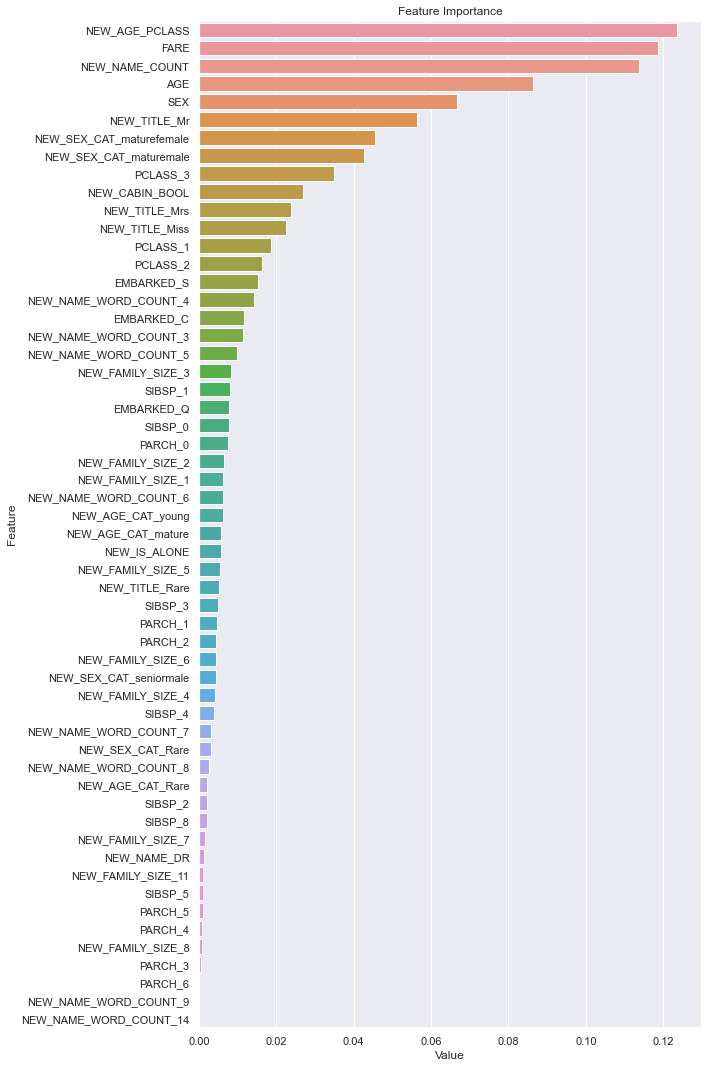

In [44]:
def plot_importance(model, X, num=len(X)):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': X.columns})
    plt.figure(figsize=(10, 15))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('importances-01.png')
    plt.show()

plot_importance(rf_model, X)